# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 1



**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

**WARNING**: There is web page scraping in this homework. It takes about 40 minutes. **Do not wait till the last minute** to do this homework.

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. There is an important CAVEAT to this. DO NOT run the web-page fetching cells again. (We have provided hints like `# DO NOT RERUN THIS CELL WHEN SUBMITTING` on some of the cells where we provide the code). Instead load your data structures from the JSON files we will ask you to save below. Otherwise you will be waiting for a long time. (Another reason to not wait until the last moment to submit.)

- Do not include your name in the notebook.

---

# Homework 1: Rihanna or Mariah?

Billboard Magazine puts out a top 100 list of "singles" every week. Information from this list, as well as that from music sales, radio, and other sources is used to determine a top-100 "singles" of the year list. A **single** is typically one song, but sometimes can be two songs which are on one "single" record.

In this homework you will: 

1. Scrape Wikipedia to obtain infprmation about the best singers and groups from each year (distinguishing between the two groups) as determined by the Billboard top 100 charts. You will have to clean this data. Along the way you will learn how to save data in json files to avoid repeated scraping. 
2. Scrape Wikipedia to obtain information on these singers. You will have to scrape the web pages, this time using a cache to guard against network timeouts (or your laptop going to sleep). You will again clean the data, and save it to a json file.
3. Use pandas to represent these two datasets and merge them.
4. Use the individual and merged datasets to visualize the performance of the artists and their songs. We have kept the amount of analysis limited here for reasons of time; but you might enjoy exploring music genres and other aspects of the music business you can find on these wikipedia pages at your own leisure.

You should have worked through Lab0 and Lab 1, and Lecture 2.  Lab 2 will help as well.

As usual, first we import the necessary libraries.  In particular, we use [Seaborn](http://stanford.edu/~mwaskom/software/seaborn/) to give us a nicer default color palette, with our plots being of large (`poster`) size and with a white-grid background. 

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

## Q1. Scraping Wikipedia for Billboard Top 100.

In this question you will scrape Wikipedia for the Billboard's top 100 singles.

### Scraping Wikipedia for Billboard singles

We'll be using  [BeautifulSoup](http://www.crummy.com/software/BeautifulSoup/), and suggest that you use Python's built in `requests` library to fetch the web page.

#### 1.1 Parsing the Billboard Wikipedia page for 1970

Obtain the web page at http://en.wikipedia.org/wiki/Billboard_Year-End_Hot_100_singles_of_1970 using a HTTP GET request. From this web page we'll extract the top 100 singles and their rankings. Create a list of dictionaries, 100 of them to be precise, with entries like 

`{'url': '/wiki/Sugarloaf_(band)', 'ranking': 30, 'band_singer': 'Sugarloaf', 'title': 'Green-Eyed Lady'}`. 

If you look at that web page, you'll see a link for every song, from which you can get the `url` of the singer or band. We will use these links later to scrape information about the singer or band. From the listing we can also get the band or singer name `band_singer`, and `title` of the song.

*HINT: look for a table with class `wikitable`.*

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

url = 'https://en.wikipedia.org/wiki/Billboard_Year-End_Hot_100_singles_of_1970'
def get_webpage_text(url):
    '''Takes url as input (str) & outputs bs4.BeautifulSoup type text'''
    url_r = requests.get(url)
    text = BeautifulSoup(url_r.text, 'html.parser')
    return text

url_text = get_webpage_text(url)

In [3]:
wikitables = url_text.find_all('table', 'wikitable')
print('There are %i wikitable(s) on this page.' %len(wikitables))
wikitable = wikitables[0]
 
def organize_1970_wikitable(wikitable, *url_column_names):
    '''Takes wikitable in HTML form & outputs pd.DataFrame'''
    rows = [row for row in wikitable.find_all('tr')]
    header_row = rows[0]
    columns = [col.get_text() for col in header_row.find_all('th') if col.get_text()]
    columns[0] = 'No.'
    url_columns = len(url_column_names)
    n_columns = len(columns)

    values, urls = [], []
    for row in rows[1:]:
        master_index = row.find_all('td')
        for i, value in enumerate(master_index):
            values.append(value.get_text())
        for i in range(1):
            try:
                first_url = str(row.find('a')).split('"')
                first_url = [a for a in first_url if a.startswith('/wiki')]
                urls.append(first_url[0])
            except IndexError:
                urls.append('')
               
    values_stacked = [values[i::n_columns] for i in range(n_columns)]
    urls_stacked = [urls[i::url_columns] for i in range(url_columns)]
    data_dict = {col:val for (col,val) in zip(columns, values_stacked)}
    data_dict.update({col:val for (col,val) in zip(url_column_names, urls_stacked)})
    df = pd.DataFrame(data_dict).rename(columns={'Artist(s)':'band_singer','No.':'ranking','Title':'title'})
    data_dict = df.to_dict('records')
    return data_dict
 
songs = organize_1970_wikitable(wikitable, 'url')
songs[2:4]
#pd.DataFrame(data_dict)

There are 1 wikitable(s) on this page.


[{'band_singer': 'The Guess Who',
  'ranking': '3',
  'title': '"American Woman"',
  'url': '/wiki/American_Woman'},
 {'band_singer': 'B.J. Thomas',
  'ranking': '4',
  'title': '"Raindrops Keep Fallin\' on My Head"',
  'url': '/wiki/Raindrops_Keep_Fallin%27_on_My_Head'}]

You should get something similar to this (where songs is the aforementioned list):

```
songs[2:4]
```

```
[{'band_singer': 'The Guess Who',
  'ranking': 3,
  'title': '"American Woman"',
  'url': '/wiki/The_Guess_Who'},
 {'band_singer': 'B.J. Thomas',
  'ranking': 4,
  'title': '"Raindrops Keep Fallin\' on My Head"',
  'url': '/wiki/B.J._Thomas'}]
```

#### 1.2 Generalize the previous: scrape Wikipedia from 1992 to 2014

By visiting the urls similar to the ones for 1970, we can obtain the billboard top 100 for the years 1992 to 2014. (We choose these later years rather than 1970 as you might find music from this era more interesting.) Download these using Python's `requests` module and store the text from those requests in a dictionary called `yearstext`. This dictionary ought to have as its keys the years (as integers from 1992 to 2014), and as values corresponding to these keys the text of the page being fetched.

You ought to sleep a second (look up `time.sleep` in Python) at the very least in-between fetching each web page: you do not want Wikipedia to think you are a marauding bot attempting to mount a denial-of-service attack.

*HINT: you might find `range` and string-interpolation useful to construct the URLs *.


In [4]:
import time

base_url = 'https://en.wikipedia.org/wiki/Billboard_Year-End_Hot_100_singles_of_'
years = [int(yr) for yr in np.arange(1992, 2015)]
url_years = [base_url + str(yr) for yr in years]

yearstext = {} 
for i, url in enumerate(url_years):
    yearstext[str(years[i])] = get_webpage_text(url)
    time.sleep(1)

#### 1.3 Parse and Clean data 

Remember the code you wrote to get data from 1970 which produces a list of dictionaries, one corresponding to each single.  Now write a function `parse_year(the_year, yeartext_dict)` which takes the year, prints it out, gets the text for the year from the just created `yearstext` dictionary, and return a list of dictionaries for that year, with one dictionary for each single. Store this list in the variable `yearinfo`.

The dictionaries **must** be of this form:

```
{'band_singer': ['Brandy', 'Monica'],
  'ranking': 2,
  'song': ['The Boy Is Mine'],
  'songurl': ['/wiki/The_Boy_Is_Mine_(song)'],
  'titletext': '" The Boy Is Mine "',
  'url': ['/wiki/Brandy_Norwood', '/wiki/Monica_(entertainer)']}
```

The spec of this function is provided below:

In [5]:
import string
flatten_list = lambda l: [item for sublist in l for item in sublist]

def replace_noise(ls):
    ls = [b.replace('[', '') for b in ls]
    ls = [b.replace(']', '') for b in ls]
    ls = [b.replace("'", '') for b in ls]
    ls = [b.replace("\\", '') for b in ls]
    return ls

def organize_modern_wikitable(wikitable, *url_column_names):
    """
    Inputs
    ------
    wikitable: bs4 BeautifulSoup object containing a WikiTable from Wikipedia
    *url_column_names: *args expecting two names for the band & song URL

    Returns
    -------
    list of dictionaries containing data scraped from Wikipedia on the top 
    songs for a given year
    """
    rows = [row for row in wikitable.find_all('tr')]
    header_row = rows[0]
    columns = [col.get_text() for col in header_row.find_all('th') if col.get_text()]
    columns[0] = 'No.'
    url_columns, n_columns = len(url_column_names), len(columns)
    song_col, band_col = str(url_column_names[0]), str(url_column_names[1])
   
    ranks, songs, bands, song_urls, band_urls = [], [], [], [], []
    rank = 1
    for row in rows[1:]:
        master_index = row.find_all('td')
        rows_urls = row.find_all('a', href=True)
        ranks.append(rank)#; print(rank)
        
        for i, row_values in enumerate(master_index):
            if i == 0:
                song = row_values.get_text()
                song = str(song).split('</a>" / "<a')
                song = str(song).split('/')
                song = replace_noise(song)
                songs.append(song)#; print(rank, song, len(song))
            else:
                band = row_values.get_text()
                band = str(band).split('</a>')
                band = [b.split('featuring') for b in band]
                band = [str(b).split('and') for b in band]
                band = flatten_list(band)
                band = replace_noise(band)
                bands.append(band)#; print(i, band)
        
        for i in range(1):
            song_urls_row = []
            try:
                song_urls_row = [s['href'] for a,s in zip(range(5), rows_urls)]
                song_urls_row = song_urls_row[:len(song)]
                song_urls.append(song_urls_row)#; print(song_urls_row)
            except IndexError:
                song_urls.append([''])
               
        for i in range(1):
            band_urls_row = []
            try:
                band_urls_row = [b['href'] for a,b in zip(range(5), rows_urls)]
                band_urls_row = band_urls_row[len(song):]
                band_urls.append(band_urls_row)#; print(band_urls_row)
            except IndexError:
                band_urls.append([''])
                
        rank += 1
               
    ranks_stacked = [ranks[i::1] for i in range(1)]#; print(ranks_stacked)
    songs_stacked = [songs[i::1] for i in range(1)]
    bands_stacked = [bands[i::1] for i in range(1)]
    song_urls_stacked = [song_urls[i::1] for i in range(1)]
    band_urls_stacked = [band_urls[i::1] for i in range(1)]
   
    data_dict = {col:val for (col,val) in zip(np.repeat('song', 100), songs_stacked)}
    data_dict.update({col:val for (col,val) in zip(np.repeat('rank', 100), ranks_stacked)})
    data_dict.update({col:val for (col,val) in zip(np.repeat('artist', 100), bands_stacked)})
    data_dict.update({col:val for (col,val) in zip(np.repeat(song_col, 100), song_urls_stacked)})
    data_dict.update({col:val for (col,val) in zip(np.repeat(band_col, 100), band_urls_stacked)})
   
    df = pd.DataFrame(data_dict)#.rename(columns={'Artist(s)':'band_singer', 'No.':'ranking', 'Title':'title', song_col:'url', band_col:'band_url'})
    df['titletext'] = df.song.astype(str).apply(lambda s: s.replace('[', ''))
    df['titletext'] = df.titletext.astype(str).apply(lambda s: s.replace(']', ''))
    df['titletext'] = df.titletext.astype(str).apply(lambda s: s.replace("'", ''))
    df['titletext'] = df.titletext.astype(str).apply(lambda s: s.replace(',', '/'))
    data_dict = df.to_dict('records')
    return data_dict
 


def parse_year(the_year, yeartext_dict):
    """
    Inputs
    ------
    the_year: the year you want the singles for
    yeartext_dict: a dictionary with keys as integer years and values the downloaded web pages 
        from wikipedia for that year.

    Returns
    -------
    a list of dictionaries, each of which corresponds to a single and has the
    following data:
    """
    print('''
    Getting data for year %s
    ''' %str(the_year))
    
    the_year = str(the_year)
    url_text = yeartext_dict[the_year]
    wikitables_yr = url_text.find_all('table', 'wikitable')
    wikitable_yr = wikitables_yr[0]
    list_of_dicts = organize_modern_wikitable(wikitable_yr, 'songurl', 'url')
    the_year = np.repeat(the_year, 100).tolist()
    return list_of_dicts, the_year

In [6]:
yearinfo, new_years = [], []
for i, item in enumerate(yearstext.items()):
    dat, yr = parse_year(the_year=years[i], yeartext_dict=yearstext)
    new_years = new_years + yr
    yearinfo.append(dat)


    Getting data for year 1992
    

    Getting data for year 1993
    

    Getting data for year 1994
    

    Getting data for year 1995
    

    Getting data for year 1996
    

    Getting data for year 1997
    

    Getting data for year 1998
    

    Getting data for year 1999
    

    Getting data for year 2000
    

    Getting data for year 2001
    

    Getting data for year 2002
    

    Getting data for year 2003
    

    Getting data for year 2004
    

    Getting data for year 2005
    

    Getting data for year 2006
    

    Getting data for year 2007
    

    Getting data for year 2008
    

    Getting data for year 2009
    

    Getting data for year 2010
    

    Getting data for year 2011
    

    Getting data for year 2012
    

    Getting data for year 2013
    

    Getting data for year 2014
    


#### Helpful notes

Notice that some singles might have multiple songs:

```
{'band_singer': ['Jewel'],
  'ranking': 2,
  'song': ['Foolish Games', 'You Were Meant for Me'],
  'songurl': ['/wiki/Foolish_Games',
   '/wiki/You_Were_Meant_for_Me_(Jewel_song)'],
  'titletext': '" Foolish Games " / " You Were Meant for Me "',
  'url': ['/wiki/Jewel_(singer)']}
```

And some singles don't have a song URL:

```
{'band_singer': [u'Nu Flavor'],
  'ranking': 91,
  'song': [u'Heaven'],
  'songurl': [None],
  'titletext': u'"Heaven"',
  'url': [u'/wiki/Nu_Flavor']}
```

Thus there are some issues this function must handle:

1. There can be more than one  `band_singer` as can be seen above (sometimes with a comma, sometimes with "featuring" in between). The best way to parse these is to look for the urls.
2. There can be two songs in a single, because of the way the industry works: there are two-sided singles. See https://en.wikipedia.org/wiki/Billboard_Year-End_Hot_100_singles_of_1997 for an example. You can find other examples in 1998 and 1999.
3. The `titletext` is the contents of the table cell, and retains the quotes that Wikipedia puts on the single.
4. If no song anchor is found (see the 24th song in the above url), assume there is one song in the single, set `songurl` to [`None`] and the song name to the contents of the table cell with the quotes stripped (ie `song` is a one-element list with this the `titletext` stripped of its quotes).

As a check, we can do this for 1997. We'll print the first 5 outputs: `parse_year(1997, yearstext)[:5]`

This should give the following. Notice that the year 1997 exercises the edge cases we talked about earlier.

```
[{'band_singer': ['Elton John'],
  'ranking': 1,
  'song': ['Something About the Way You Look Tonight',
   'Candle in the Wind 1997'],
  'songurl': ['/wiki/Something_About_the_Way_You_Look_Tonight',
   '/wiki/Candle_in_the_Wind_1997'],
  'titletext': '" Something About the Way You Look Tonight " / " Candle in the Wind 1997 "',
  'url': ['/wiki/Elton_John']},
 {'band_singer': ['Jewel'],
  'ranking': 2,
  'song': ['Foolish Games', 'You Were Meant for Me'],
  'songurl': ['/wiki/Foolish_Games',
   '/wiki/You_Were_Meant_for_Me_(Jewel_song)'],
  'titletext': '" Foolish Games " / " You Were Meant for Me "',
  'url': ['/wiki/Jewel_(singer)']},
 {'band_singer': ['Puff Daddy', 'Faith Evans', '112'],
  'ranking': 3,
  'song': ["I'll Be Missing You"],
  'songurl': ['/wiki/I%27ll_Be_Missing_You'],
  'titletext': '" I\'ll Be Missing You "',
  'url': ['/wiki/Sean_Combs', '/wiki/Faith_Evans', '/wiki/112_(band)']},
 {'band_singer': ['Toni Braxton'],
  'ranking': 4,
  'song': ['Un-Break My Heart'],
  'songurl': ['/wiki/Un-Break_My_Heart'],
  'titletext': '" Un-Break My Heart "',
  'url': ['/wiki/Toni_Braxton']},
 {'band_singer': ['Puff Daddy', 'Mase'],
  'ranking': 5,
  'song': ["Can't Nobody Hold Me Down"],
  'songurl': ['/wiki/Can%27t_Nobody_Hold_Me_Down'],
  'titletext': '" Can\'t Nobody Hold Me Down "',
  'url': ['/wiki/Sean_Combs', '/wiki/Mase']}]
```

#### Save a json file of information from the scraped files

We do not want to lose all this work, so let's save the last data structure we created to disk. That way if you need to re-run from here, you don't need to redo all these requests and parsing. 

DO NOT RERUN THE HTTP REQUESTS TO WIKIPEDIA WHEN SUBMITTING.

*We **DO NOT** need to see these JSON files in your submission!*

In [7]:
import json
import os

In [ ]:
# # DO NOT RERUN THIS CELL WHEN SUBMITTING
# json_path = str(os.getcwd()) + '/yearinfo.json'
# fd = open(json_path, 'w')
# json.dump(yearinfo, fd)
# fd.close()
# del yearinfo

Now let's reload our JSON file into the yearinfo variable, just to be sure everything is working.

In [8]:
# RERUN WHEN SUBMITTING
# Another way to deal with files. Has the advantage of closing the file for you.
json_path = str(os.getcwd()) + '/yearinfo.json'
with open(json_path, 'r') as fd:
    yearinfo = json.load(fd)

#### 1.4 Construct a year-song-singer dataframe from the yearly information

Let's construct a dataframe `flatframe` from the `yearinfo`. The frame should be similar to the frame below.  Each row of the frame represents a song, and carries with it the chief properties of year, song, singer, and ranking.

![](https://raw.githubusercontent.com/cs109/a-2017/master/hwassets/images/HW1SC1.png)

In [9]:
df = pd.DataFrame()

for i, ls in enumerate(yearinfo):
    new_df = pd.DataFrame.from_dict(ls)
    df = df.append(new_df, ignore_index=True)

df['year'] = new_years
df.tail()

,artist,rank,song,songurl,titletext,url,year
2295,"[ScHoolboy Q , BJ the Chicago Kid]",96,"[""Studio""]",[/wiki/Studio_(song)],"""Studio""","[/wiki/ScHoolboy_Q, /wiki/BJ_the_Chicago_Kid]",2014
2296,[Drake],97,"[""0 to 100 , The Catch Up""]","[/wiki/0_to_100_/_The_Catch_Up, /wiki/Drake_(r...","""0 to 100 / The Catch Up""",[],2014
2297,[Lee Brice],98,"[""I Dont Dance""]",[/wiki/I_Don%27t_Dance_(Lee_Brice_song)],"""I Dont Dance""",[/wiki/Lee_Brice],2014
2298,"[Mir, a Lambert , Carrie Underwood]",99,"[""Somethin Bad""]",[/wiki/Somethin%27_Bad],"""Somethin Bad""","[/wiki/Miranda_Lambert, /wiki/Carrie_Underwood]",2014
2299,[Miley Cyrus],100,"[""Adore You""]",[/wiki/Adore_You],"""Adore You""",[/wiki/Miley_Cyrus],2014


To construct the dataframe, we'll need to iterate over the years and the singles per year. Notice how, above, the dataframe is ordered by ranking and then year. While the exact order is up to you, note that you will have to come up with a scheme to order the information.

Check that the dataframe has sensible data types. You will also likely find that the year field has become an "object" (Pandas treats strings as generic objects): this is due to the conversion to and back from JSON. Such conversions need special care. Fix any data type issues with `flatframe`. (See Pandas [astype](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.astype.html) function.) 
We will use this `flatframe` in the next question. 

(As an aside, we used the name `flatframe` to indicate that this dataframe is flattened from a hierarchical dictionary structure with the keys being the years.)

In [10]:
print('Before:\n\n', df.dtypes, '\n')
df[['rank','year']] = df[['rank','year']].astype(int)
df[['artist','song','songurl','titletext','url']] = df[['artist','song','songurl','titletext','url']].astype(str)
print('After:\n\n', df.dtypes)
df.head()

Before:

 artist       object
rank          int64
song         object
songurl      object
titletext    object
url          object
year         object
dtype: object 

After:

 artist       object
rank          int64
song         object
songurl      object
titletext    object
url          object
year          int64
dtype: object


,artist,rank,song,songurl,titletext,url,year
0,['Boyz II Men'],1,"['""End of the Road""']",['/wiki/End_of_the_Road'],"""End of the Road""",['/wiki/Boyz_II_Men'],1992
1,['Sir Mix-a-Lot'],2,"['""Baby Got Back""']",['/wiki/Baby_Got_Back'],"""Baby Got Back""",['/wiki/Sir_Mix-a-Lot'],1992
2,['Kris Kross'],3,"['""Jump""']",['/wiki/Jump'],"""Jump""",['/wiki/Kris_Kross'],1992
3,['Vanessa Williams'],4,"['""Save the Best for Last""']",['/wiki/Save_the_Best_for_Last'],"""Save the Best for Last""",['/wiki/Vanessa_L._Williams'],1992
4,['TLC'],5,"['""Baby-Baby-Baby""']",['/wiki/Baby-Baby-Baby'],"""Baby-Baby-Baby""",['/wiki/TLC_(band)'],1992


### Who are the highest quality singers?

Here we show the highest quality singers and plot them on a bar chart.

#### 1.5 Find highest quality singers according to how prolific they are

What do we mean by highest quality? This is of course open to interpretation, but let's define "highest quality" here as the number of times a singer appears in the top 100 over this time period. If a singer appears twice in a year (for different songs), this is counted as two appearances, not one. 

Make a bar-plot of the most prolific singers. Singers on this chart should have appeared at-least more than 15 times. (HINT: look at the docs for the pandas method `value_counts`.)


/Users/pmw/anaconda/lib/python3.6/site-packages/pandas/core/groupby.py:3961: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)
/Users/pmw/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]


,rank|high,rank|mean,billboard_hits,year|debut,year|swan,career_duration,years_since_top100,avg_rank_weighted,avg_rank_weighted_career
artist,,,,,,,,,
['Pink'],97,43.941176,15,2000,2013,13,4,659.117647,50.701357
['Rihanna'],94,42.722222,15,2005,2013,8,4,640.833333,80.104167
['Mariah Carey'],50,24.000000,17,1992,2009,17,8,408.000000,24.000000


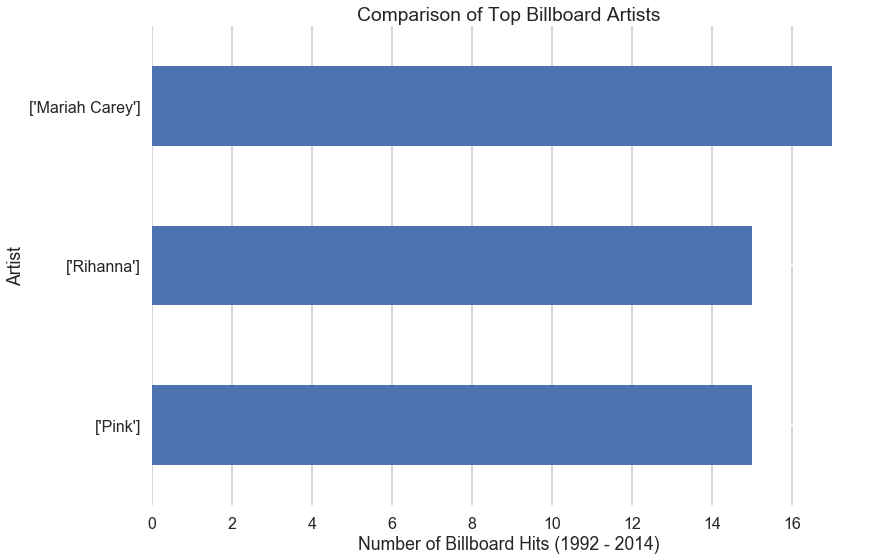

In [11]:
import datetime
import seaborn as sns

len_unique = lambda x: len(pd.Series.unique(x))
agg_funcs = {'rank': {'high':np.max, 'mean':np.mean}, 'song': len_unique, 'year': {'debut':np.min, 'swan':np.max}}
grp_cols = ['artist']
df_grp = pd.DataFrame(df.groupby(grp_cols).agg(agg_funcs))
df_grp.columns = ['%s%s' % (a, '|%s' % b if b else '') for a, b in df_grp.columns]
df_grp['career_duration'] = df_grp['year|swan'] - df_grp['year|debut']
df_grp['years_since_top100'] = datetime.date.today().year - df_grp['year|swan']
df_grp.rename(columns={'song|<lambda>':'billboard_hits'}, inplace=True)
df_grp['avg_rank_weighted'] = np.multiply(df_grp['rank|mean'], df_grp['billboard_hits'])
df_grp['avg_rank_weighted_career'] = np.divide(df_grp['avg_rank_weighted'], df_grp['career_duration'])
df_grp = df_grp.sort_values(by='avg_rank_weighted', ascending=False)
df_top_singers = df_grp[df_grp.billboard_hits >= 15]

with sns.plotting_context('poster'):
    sns.axes_style('whitegrid');
    ax = plt.gca();
    df_top_singers['billboard_hits'].plot(kind='barh')
    plt.grid(axis='y', color='white', linestyle='-');
    ax.tick_params(axis='both', which='both', length=0);
    sns.despine(left=True, bottom=True);
    plt.title('Comparison of Top Billboard Artists');
    plt.ylabel('Artist');
    plt.xlabel('Number of Billboard Hits (1992 - 2014)')

df_top_singers

## Answer: Who are the highest quality singers?

Using the number of top 100 hits as a measure (and considering only artists with 15 or more hits), the most prolific singers appear to be Mariah Carey, Rihanna, and Pink.

This is a very one-dimensional view of quality, and is likely an incomplete picture of an artist.

#### 1.6 What if we used a different metric?

What we would like to capture is this: a singer should to be scored higher if the singer appears higher in the rankings. So we'd say that a singer who appeared once at a higher and once at a lower ranking is a "higher quality" singer than one who appeared twice at a lower ranking. 

To do this, group all of a singers songs together and assign each song a score `101 - ranking`. Order the singers by their total score and make a bar chart for the top 20.

Using this metric changes the ranking considerably. 

In [12]:
df_grp_songs = pd.DataFrame(df.groupby(['artist','song'])['rank'].mean()).reset_index(drop=False)
df_grp_songs['song_score'] = np.subtract(101, df_grp_songs['rank'])
df_grp_songs = pd.DataFrame(df_grp_songs.groupby('artist')['song_score'].sum())
df_grp_songs = df_grp_songs.sort_values('song_score', ascending=False)
df_grp = df_grp.join(df_grp_songs)
df_grp.head(20)

,rank|high,rank|mean,billboard_hits,year|debut,year|swan,career_duration,years_since_top100,avg_rank_weighted,avg_rank_weighted_career,song_score
artist,,,,,,,,,,
['Britney Spears'],87,59.125000,14,1999,2011,12,6,827.750000,68.979167,605.5
['Madonna'],99,54.400000,14,1992,2006,14,11,761.600000,54.400000,675.5
['R. Kelly'],94,58.461538,12,1994,2004,10,13,701.538462,70.153846,538.0
['Eminem'],98,61.250000,11,2000,2013,13,4,673.750000,51.826923,421.5
['Pink'],97,43.941176,15,2000,2013,13,4,659.117647,50.701357,877.0
['Rihanna'],94,42.722222,15,2005,2013,8,4,640.833333,80.104167,896.5
['Kelly Clarkson'],95,48.875000,13,2002,2013,11,4,635.375000,57.761364,721.5
['Aaliyah'],96,61.636364,10,1994,2003,9,14,616.363636,68.484848,414.0
['The Black Eyed Peas'],95,43.750000,14,2003,2011,8,6,612.500000,76.562500,767.5


#### 1.7 Do you notice any major differences when you change the metric?

How have the singers at the top shifted places? Why do you think this happens?

Mariah Carey is not even on the chart for the top 20 by this metric. This may indicate that Mariah Carey is good at making songs good enough to get into the top 100, yet does not consistently score high on the chart's overall ranking. The previous measure is a measure of consistency, while this is a measure of overall quality.

## Q2. Scraping and Constructing: Information about Artists, Bands and Genres from Wikipedia

Our next job is to use those band/singer urls we collected under `flatframe.url` and get information about singers and/or bands.

### Scrape information about artists from wikipedia

We wish to fetch information about the singers or groups for all the winning songs in a list of years.

Here we show a function that fetches information about a singer or group from their url on wikipedia. We create a cache object `urlcache` that will avoid redundant HTTP requests (e.g. an artist might have multiple singles on a single year, or be on the list over a span of years). Once we have fetched information about an artist, we don't need to do it again. The caching also helps if the network goes down, or the target website is having some problems. You simply need to run the `get_page` function below again, and the `urlcache` dictionary will continue to be filled.

If the request gets an HTTP return code different from 200, (such as a 404 not found or 500 Internal Server Error) the cells for that URL will have a value of 1; and if the request completely fails (e.g. no network connection) the cell will have a value of 2. This will allow you to analyse the failed requests.

Notice that we have wrapped the call in whats called _an exception block_. We try to make the request. If it fails entirely, or returns a HTTP code thats not 200, we set the status to 2 and 1 respectively.

In [13]:
urlcache={}

In [14]:
def get_page(url):
    # Check if URL has already been visited.
    if (url not in urlcache) or (urlcache[url]==1) or (urlcache[url]==2):
        time.sleep(1)
        # try/except blocks are used whenever the code could generate an exception (e.g. division by zero).
        # In this case we don't know if the page really exists, or even if it does, if we'll be able to reach it.
        try:
            r = requests.get("http://en.wikipedia.org%s" % url)

            if r.status_code == 200:
                urlcache[url] = r.text
            else:
                urlcache[url] = 1
        except:
            urlcache[url] = 2
    return urlcache[url]

We sort the `flatframe` by year, ascending, first. Think why.

In [15]:
flatframe = df.sort_values('year')
flatframe.head()

,artist,rank,song,songurl,titletext,url,year
0,['Boyz II Men'],1,"['""End of the Road""']",['/wiki/End_of_the_Road'],"""End of the Road""",['/wiki/Boyz_II_Men'],1992
72,['Paula Abdul'],73,"['""Blowing Kisses in the Wind""']",['/wiki/Blowing_Kisses_in_the_Wind'],"""Blowing Kisses in the Wind""",['/wiki/Paula_Abdul'],1992
71,['Ugly Kid Joe'],72,"['""Everything About You""']",['/wiki/Everything_About_You_(Ugly_Kid_Joe_son...,"""Everything About You""",['/wiki/Ugly_Kid_Joe'],1992
70,['The Cure'],71,"['""Friday Im in Love""']",['/wiki/Friday_I%27m_in_Love'],"""Friday Im in Love""",['/wiki/The_Cure'],1992
69,['Bryan Adams'],70,"['""Do I Have to Say the Words?""']",['/wiki/Do_I_Have_to_Say_the_Words%3F'],"""Do I Have to Say the Words?""",['/wiki/Bryan_Adams'],1992


#### Pulling and saving the data

In [ ]:
print('''# # DO NOT RERUN THIS CELL WHEN SUBMITTING
# # Here we are populating the url cache
# # subsequent calls to this cell should be very fast, since Python won't
# # need to fetch the page from the web server.
# # NOTE this function will take quite some time to run (about 30 mins for me), since we sleep 1 second before
# # making a request. If you run it again it will be almost instantaneous, save requests that might have failed
# # (you will need to run it again if requests fail..see cell below for how to test this)
# flatframe["url"].apply(get_page)''')

You may have to run this function again and again, in case there were network problems. Note that, because there is a "global" cache, it will take less time each time you run it. Also note that this function is designed to be run again and again: it attempts to make sure that there are no unresolved pages remaining. Let us make sure of this: *the sum below should be 0, and the boolean True.*

In [ ]:
print('''
# # DO NOT RERUN THIS CELL WHEN SUBMITTING
# print("Number of bad requests:",np.sum([(urlcache[k]==1) or (urlcache[k]==2) for k in urlcache])) # no one or 0's)
# print("Did we get all urls?", len(flatframe.url.unique())==len(urlcache)) # we got all of the urls''')

Let's save the `urlcache` to disk, just in case we need it again.

In [ ]:
print('''# # DO NOT RERUN THIS CELL WHEN SUBMITTING
# with open("data/artistinfo.json","w") as fd:
#     json.dump(urlcache, fd)
# del urlcache''')

In [16]:
# RERUN WHEN SUBMITTING
with open("data/artistinfo.json") as json_file:
    urlcache = json.load(json_file)

#### 2.1 Extract information about singers and bands

From each page we collected about a singer or a band, extract the following information:

1. If the page has the text "Born" in the sidebar on the right, extract the element with the class `.bday`. If the page doesn't contain "Born", store `False`.  Store either of these into the variable `born`. We want to analyze the artist's age.

2. If the text "Years active" is found, but no "born", assume a band. Store into the variable `ya` the value of the next table cell corresponding to this, or `False` if the text is not found.

Put this all into a function `singer_band_info` which takes the singer/band url as argument and returns a dictionary `dict(url=url, born=born, ya=ya)`.

The information can be found on the sidebar on each such wikipedia page, as the example here shows:

![sandg](https://raw.githubusercontent.com/cs109/a-2017/master/hwassets/images/sandg.png).



Write the function `singer_band_info` according to the following specification:

In [17]:
import re

def process_url(url):
    '''Cleans up the url for querying the internet'''
    url = str(url).replace("'", '')
    url = url.replace('[', '')
    url = url.replace(']', '')
    url = 'https://en.wikipedia.org' + url
    return url

def singer_band_info(url, page_text):
    '''
    Function
    --------
    singer_band_info

    Inputs
    ------
    url: the url, processed & ready for browsing
    page_text: the text associated with the url

    Returns
    -------
    A dictionary with the following data:
    url: copy the input argument url into this value
    born: the artist's birthday
    ya: years active variable
    '''
    find_ya = re.compile(r'\d{4}\–\b\d{4}\b')
    try:
        bday_info = page_text.find_all('span', {'class':'bday'})
        bday_info = [bday.get_text() if len(bday_info)==1 else False for bday in bday_info]
        if len(bday_info) != 1: bday_info = [False]
        bday_info = str(bday_info)
        
        ya_info = page_text.find_all('table', {'class':'infobox'})
        ya_info = flatten_list([ya.find_all('td') for ya in ya_info])
        ya_info = [ya.get_text() for ya in ya_info]#; print(ya_info, '\n')
        ya_info = flatten_list([str(ya).split('\n') for ya in ya_info])#; print(ya_info, '\n')
        ya_info = flatten_list([str(ya).split(',') for ya in ya_info])#; print(ya_info, '\n')
        ya_info = [str(ya).replace('present', '2017') for ya in ya_info]#; print(ya_info, '\n')
        ya_info = [find_ya.search(str(ya).replace('–present', '2017')).group() \
                   for ya in ya_info if find_ya.search(str(ya)) != None]#; print(ya_info)
    except:
        ya_info = bday_info = ''
    
    data_dict = {'url':url, 'born':bday_info, 'ya':ya_info}
    return data_dict

artist_urls = [item[0] for item in urlcache.items()]
artist_urls = artist_urls

artist_info_ls = []
for raw_url in artist_urls:
    try:
        url = process_url(raw_url)#; print(url)
        page_text = get_webpage_text(url)
        artist_info_ls.append(singer_band_info(url, page_text))
    except:
        pass

artist_info_ls[:5]

[{'born': '[False]',
  'url': 'https://en.wikipedia.org/wiki/Boyz_II_Men',
  'ya': ['1985–2017']},
 {'born': "['1962-06-19']",
  'url': 'https://en.wikipedia.org/wiki/Paula_Abdul',
  'ya': ['1978–2017']},
 {'born': '[False]',
  'url': 'https://en.wikipedia.org/wiki/Ugly_Kid_Joe',
  'ya': ['1987–1997', '2010–2017']},
 {'born': '[False]',
  'url': 'https://en.wikipedia.org/wiki/The_Cure',
  'ya': ['1976–2017']},
 {'born': "['1959-11-05']",
  'url': 'https://en.wikipedia.org/wiki/Bryan_Adams',
  'ya': ['1975–2017']}]

#### 2.2  Merging this information in

Iterate over the items in the singer-group dictionary cache `urlcache`, run the above function, and create a dataframe from there with columns `url`, `born`, and `ya`. Merge this dataframe on the `url` key with `flatframe`, creating a rather wide dataframe that we shall call `largedf`. It should look something like this:

![](https://raw.githubusercontent.com/cs109/a-2017/master/hwassets/images/HW1SC3.png)

Notice how the `born` and `ya` and `url` are repeated every time a different song from a given band is represented in a row.

In [18]:
artist_df = pd.DataFrame()

get_first_url = lambda s: str(s).split(']')[0]
get_song_url = lambda s: str(s).split('.org')[1]

for i, ls in enumerate(artist_info_ls):
    new_df = pd.DataFrame.from_dict(ls)
    artist_df = artist_df.append(new_df, ignore_index=True)

artist_df['merge_url'] = artist_df.url.astype(str).apply(get_song_url)
artist_df.merge_url = artist_df.merge_url.astype(str)
artist_df.merge_url = artist_df.merge_url.apply(lambda s: str(s).replace(' ', ''))
artist_df.rename(columns={'url':'browse_url'}, inplace=True)

df['merge_url'] = df.url.astype(str).apply(get_first_url)
df.merge_url = df.merge_url.apply(lambda s: str(s).replace("'",''))
df.merge_url = df.merge_url.apply(lambda s: str(s).replace("[",''))
df.merge_url = df.merge_url.replace(" ",'')
df.merge_url = df.merge_url.astype(str)

df = df.merge(artist_df, on='merge_url', how='inner')
df.head()

,artist,rank,song,songurl,titletext,url,year,merge_url,born,browse_url,ya
0,['Boyz II Men'],1,"['""End of the Road""']",['/wiki/End_of_the_Road'],"""End of the Road""",['/wiki/Boyz_II_Men'],1992,/wiki/Boyz_II_Men,[False],https://en.wikipedia.org/wiki/Boyz_II_Men,1985–2017
1,['Boyz II Men'],37,"['""Its So Hard to Say Goodbye to Yesterday""']",['/wiki/It%27s_So_Hard_to_Say_Goodbye_to_Yeste...,"""Its So Hard to Say Goodbye to Yesterday""",['/wiki/Boyz_II_Men'],1992,/wiki/Boyz_II_Men,[False],https://en.wikipedia.org/wiki/Boyz_II_Men,1985–2017
2,['Boyz II Men'],84,"['""Uhh Ahh""']",['/wiki/Uhh_Ahh'],"""Uhh Ahh""",['/wiki/Boyz_II_Men'],1992,/wiki/Boyz_II_Men,[False],https://en.wikipedia.org/wiki/Boyz_II_Men,1985–2017
3,['Boyz II Men'],12,"['""In the Still of the Nite""']",['/wiki/In_the_Still_of_the_Night_(1956_song)#...,"""In the Still of the Nite""",['/wiki/Boyz_II_Men'],1993,/wiki/Boyz_II_Men,[False],https://en.wikipedia.org/wiki/Boyz_II_Men,1985–2017
4,['Boyz II Men'],3,"['""Ill Make Love to You""']",['/wiki/I%27ll_Make_Love_to_You'],"""Ill Make Love to You""",['/wiki/Boyz_II_Men'],1994,/wiki/Boyz_II_Men,[False],https://en.wikipedia.org/wiki/Boyz_II_Men,1985–2017


#### 2.3 What is the age at which singers achieve their top ranking?

Plot a histogram of the age at which singers achieve their top ranking. What conclusions can you draw from this distribution of ages?

*HINT: You will need to do some manipulation of the `born` column, and find the song for which a band or an artist achieves their top ranking. You will then need to put these rows together into another dataframe or array to make the plot.*


The average age of an artist when they have a top 100 hit is 28.3



/Users/pmw/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/pmw/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:2999: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/Users/pmw/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org

,artist,rank,top_single,age_top_single,top_rank,top_single_year
0,"['""DAngelo""']",86,"['""Brown Sugar""']",21,86,1995
1,"['""DAngelo""']",86,"['""Lady""']",22,70,1996
2,"['""Desree""']",20,"['""You Gotta Be""']",27,20,1995


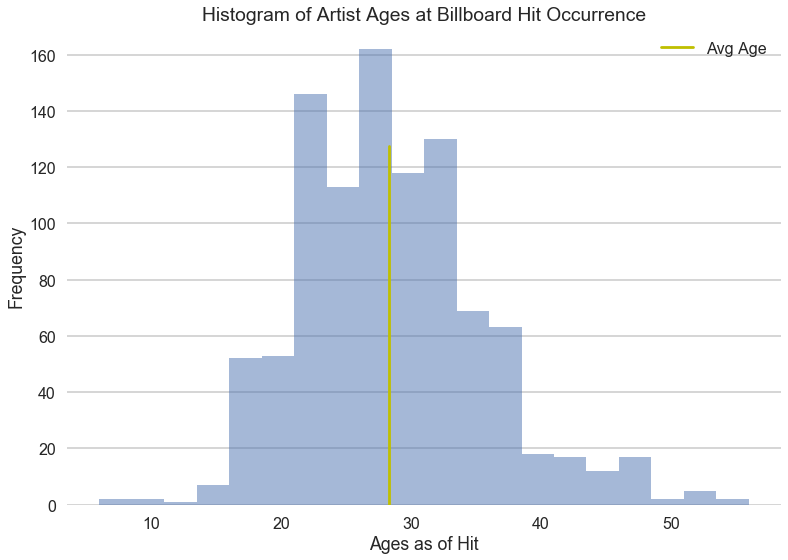

In [19]:
def add_artist_features(df):
    df.born = df.born.astype(str).apply(lambda s: str(s).replace("[", ''))
    df.born = df.born.astype(str).apply(lambda s: str(s).replace("]", ''))
    df.born = df.born.astype(str).apply(lambda s: str(s).replace("'", ''))
    df = df[df.born != 'False']
    df['year_born'] = df.born.astype(str).apply(lambda s: s[:4])
    df.year_born = df.year_born.astype(int)
    df['age_at_song'] = df.year - df.year_born
    return df

df_enrich = add_artist_features(df)

def extract_top_hits(df_enrich):
    df_enrich = df_enrich[['artist','song','age_at_song','rank','year']].drop_duplicates()
    df = pd.DataFrame(df_enrich.groupby('artist')[['rank']].max()).reset_index(drop=False)
    df = df.merge(df_enrich, on='artist', how='inner')
    colnames = {'song':'top_single', 'age_at_song':'age_top_single', 'rank_x':'rank',\
                'rank_y':'top_rank', 'year':'top_single_year'}
    df.rename(columns=colnames, inplace=True)
    return df

df_artist_top_hits = extract_top_hits(df_enrich)
avg_age_at_hit = df_artist_top_hits.age_top_single.mean()

print('''
The average age of an artist when they have a top 100 hit is %.1f
''' %avg_age_at_hit)

with sns.plotting_context('poster'):
    sns.axes_style('whitegrid');
    ax = plt.gca();
    plt.axvline(avg_age_at_hit, 0, .75, color='y', label='Avg Age');
    df_artist_top_hits.age_top_single.hist(bins=20, alpha=0.5);
    plt.grid(axis='x', color='w', linestyle='-');
    ax.tick_params(axis='both', which='both', length=0);
    sns.despine(left=True, bottom=True);
    plt.title('Histogram of Artist Ages at Billboard Hit Occurrence');
    plt.ylabel('Frequency');
    plt.xlabel('Ages as of Hit');
    plt.legend()

df_artist_top_hits.head(3)

It appears that artists in this sample set reach their maximum score at around 28 years old. The distribution appears to approximate a normal distribution with a slight right-skew. This is a potential indicator that some artists are able to continue beating their "best" ranks as they get older, while others seem to hit their max rank in their early twenties and never top it.

#### 2.4 At what year since inception do bands reach their top rankings?

Make a similar calculation to plot a histogram of the years since inception at which bands reach their top ranking. What conclusions can you draw?

In [20]:
def add_artist_longevity_features(df):
    active_yrs = [str(yr).split('–') for yr in df.ya]
    df['debut'] = [yr[0] for yr in active_yrs]
    df['hiatus'] = [yr[1] for yr in active_yrs]
    df['reunion'] = [yr[2] if len(yr)>2 else 0 for yr in active_yrs]
    df['retire'] = [yr[3] if len(yr)>3 else 0 for yr in active_yrs]
    df['career_duration'] = np.subtract(df.hiatus.astype(int), df.debut.astype(int)) \
        + np.subtract(df.retire.astype(int), df.reunion.astype(int))
    return df

df_enrich = add_artist_longevity_features(df_enrich)

/Users/pmw/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/pmw/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/pmw/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe


The average no. of years from debut until artist has their top hit on the top 100 list is 8.0



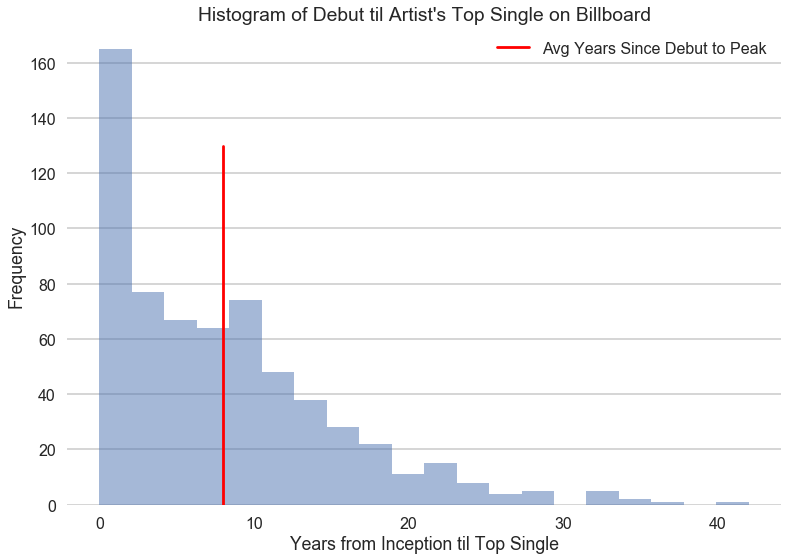

In [21]:
df_enrich = df_enrich.merge(df_artist_top_hits, left_on=['artist','rank','year'], \
                            right_on=['artist','rank','top_single_year'], how='inner')

df_enrich['debut'] = [a if a<b else b for a,b in zip(df_enrich.debut.astype(int), df_enrich.top_single_year.astype(int))]
df_enrich['yrs_inception'] = np.subtract(df_enrich.top_single_year.astype(int), df_enrich.debut.astype(int))
avg_yrs_inception = df_enrich.yrs_inception.mean()

print('''
The average no. of years from debut until artist has their top hit on the top 100 list is %.1f
''' %avg_yrs_inception)

with sns.plotting_context('poster'):
    sns.axes_style('whitegrid');
    ax = plt.gca();
    plt.axvline(avg_yrs_inception, 0, .75, color='r', label='Avg Years Since Debut to Peak');
    df_enrich.yrs_inception.hist(bins=20, alpha=0.5);
    plt.grid(axis='x', color='w', linestyle='-');
    ax.tick_params(axis='both', which='both', length=0);
    sns.despine(left=True, bottom=True);
    plt.title('Histogram of Debut til Artist\'s Top Single on Billboard');
    plt.ylabel('Frequency');
    plt.xlabel('Years from Inception til Top Single');
    plt.legend()

It appears that the vast majority of artists have a meteoric rise to stardom, making it to their lifetime highest ranking on the list within their first year on the scene. It is interesting to note that a considerable number of artists achieved their personal best rank at or after ten years since their debut. Furthere investigation is warranted to look into any themes that may exist between these two groups (one-hit-wonders vs. slow-but-steadies).